### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [1]:
#for interactive plots
# %matplotlib ipympl

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Problem 1
*As I warned in class, there are many, many deeply flawed pseudo-random number generators out there. One widely found version is the default random number generator in the C standard library. Look at test broken libc.py - this shows how to wrap the C standard library in python, call its random number generator, and save the output. (Note the numba wrapper is there for speed but is not required.) I’ve used it to generate random (x,y,z) positions with coordinates between 0 and 2^31 (the max random integer value in the standard library). The type of PRNG used in the library is notorious for introducing correlations between sequential points, with sets of points in n−dimensional space lying on a surprisingly small number of planes.*

*To make this effect easier to see, I’ve pulled out all the (x,y,z) triples
with 0 < x, y, z < 10^8 (so about 5% of the total span) and put them in the text file rand points.txt. Show that when correctly viewed, these triples lie along a set of planes (I get about 30) and so are very much not randomly distributed in 3D space. You can either do this by changing the view angle on a 3D plot, or plotting $(ax + by, z)$ for suitably chosen a and b. Do you see the same thing happen with python’s random number generator? If possible, can you see the same effect on your local machine? You may need to change the name of the library in the line: mylib=ctypes.cdll.LoadLibrary(“libc.dylib”) where libc.so would be standard under a Linux system, and you can google for Windows. If you can’t get this part to work, that’s OK - just state so and you won’t lose points.*

In [3]:
triples = np.transpose(np.loadtxt("rand_points.txt"))

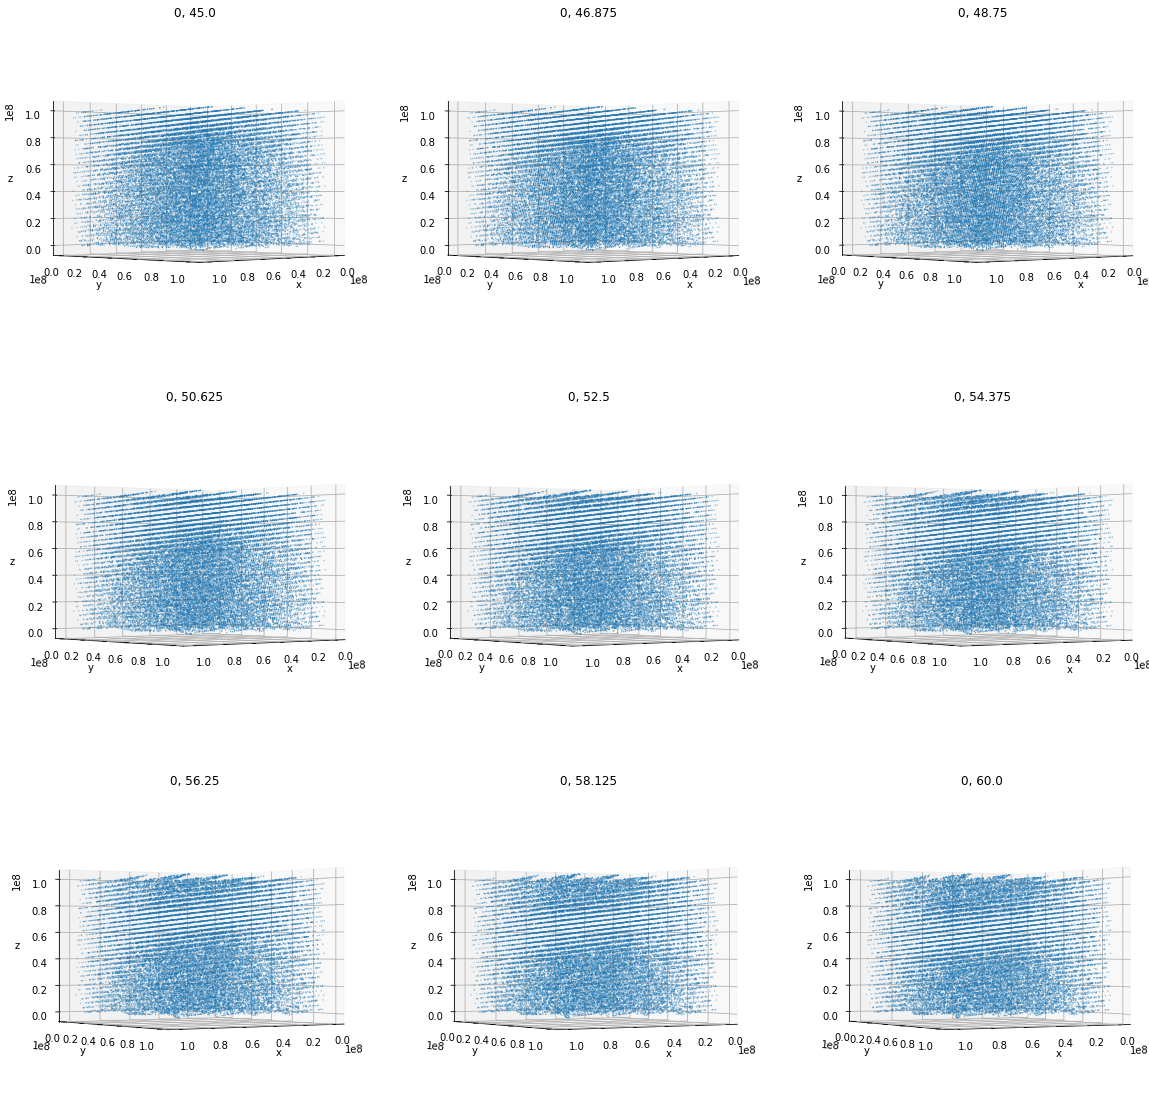

In [185]:
#I played around with the view using an interactive plot, but here's the view for a couple angles
x = np.linspace(45, 60, 9)
a = 0
# b = 80
            
fig = plt.figure(figsize=(20,20))

for i, b in enumerate(x):
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    #making the points pretty small so it isn't just a blob
    ax.scatter(triples[0], triples[1], zs=triples[2], s=0.1) 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("{}, {}".format(a, b))

    ax.view_init(a, b)
    
plt.show()

Text(0.5, 0, 'z')

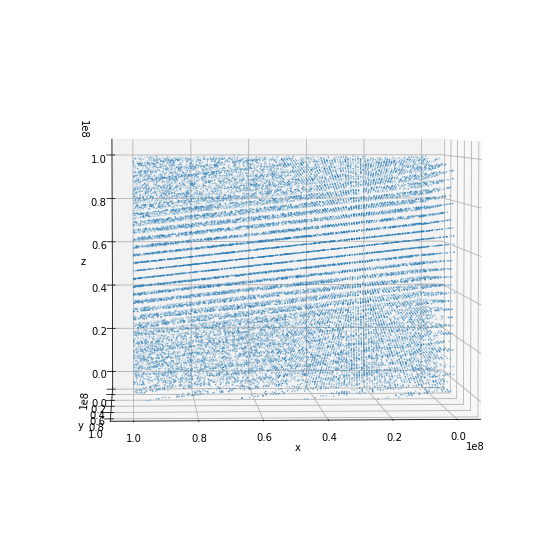

In [184]:
# at this angle, you can really see most of the planes, definitly order of 30

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=Axes3D.name)
ax.scatter(triples[0], triples[1], zs=triples[2], s=0.1)
ax.view_init(3, 87)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [2]:
"""
Now generating random integers from python's np.random.ranint 
in a similar fashion to previous ones from C.
This cell is pretty slow.
"""

n=300000000

#getting our points
vec = np.random.randint(0, 2**31, n*3)
#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])

vmax=np.max(vv,axis=1)

In [3]:
maxval=1e8
#taking only those less than 1e8
pythonTriples=np.transpose(vv[vmax<maxval,:])

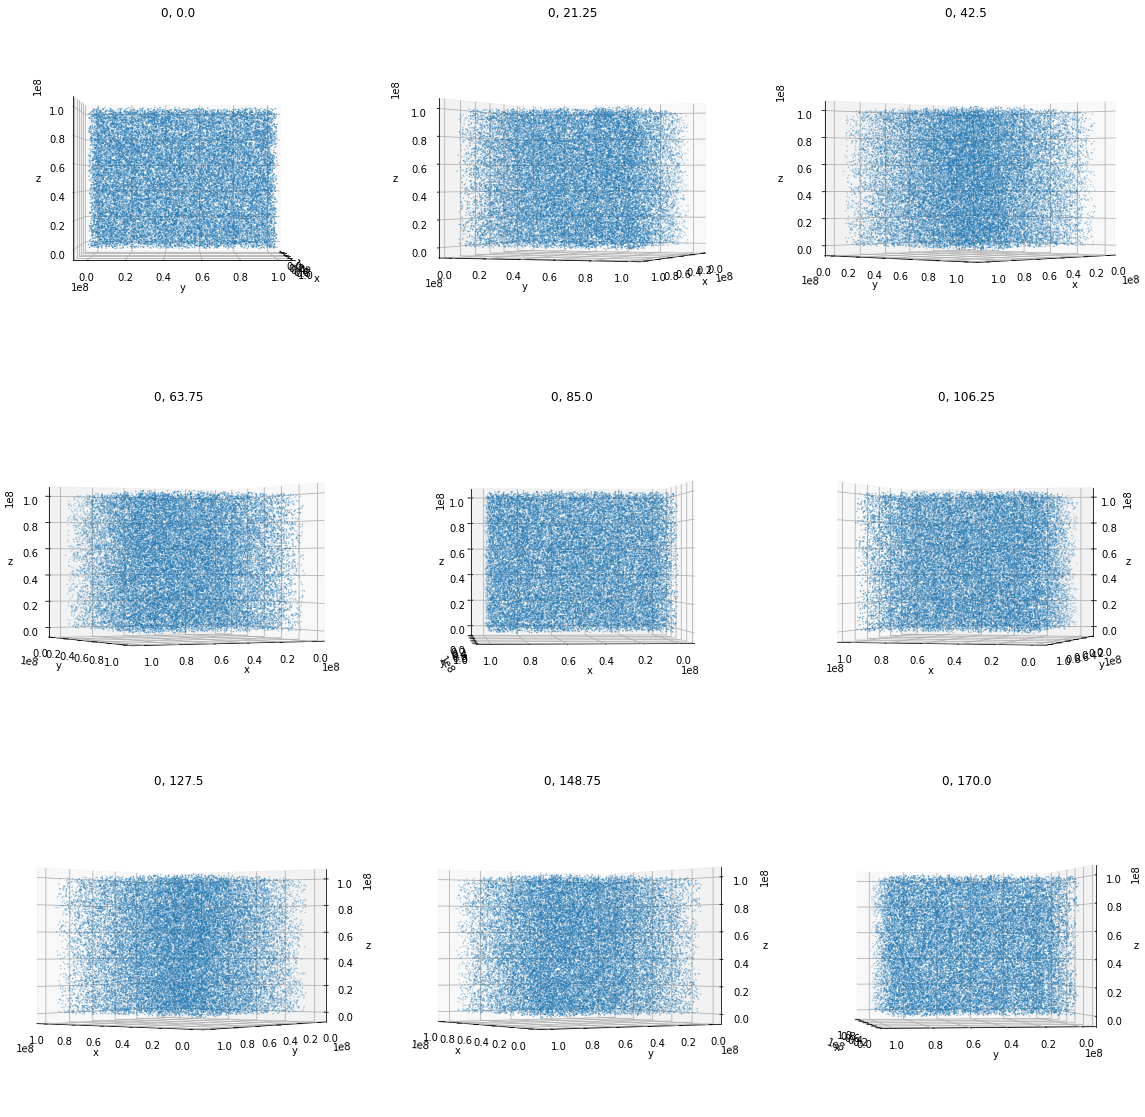

In [4]:
#plotting for multiple angles again
x = np.linspace(0, 170, 9)
a = 0
# b = 80

fig = plt.figure(figsize=(20,20))

for i, b in enumerate(x):
#     print(a)
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter(pythonTriples[0], pythonTriples[1], zs=pythonTriples[2], s=0.1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("{}, {}".format(a, b))

    ax.view_init(a, b)
    
plt.show()

As seen above, with Python's np.random.ranint we don't see any correlation between the generated values.

In [ ]:
# libc.so on windows

"""
dir libc.so /s //finds nothing

I tried to find the match library for windows, but I was unsuccessful.

"""

### Problem 2
We saw in class how to generate exponential deviates using a transformation. Now write a rejection method to generate exponential deviates from another distribution. Which of Lorentzians, Gaussians, and power laws could you use for the bounding distribution? You can assume the exponential deviates are non-negative (since you have to cut off the distribution somewhere, might as well be at zero). Show that a histogram of your deviates matches up with the expected exponential curve. How efficient can you make this generator, in terms of the fraction of uniform deviates that give rise to an exponential deviate?

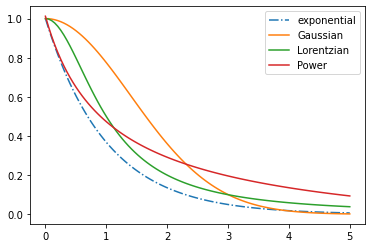

In [5]:
#comparing functions to use
def gauss(x, sig):
    return np.exp(-(x)**2/(2*sig**2))

def lor(x):
    return 1/(1 + x**2)

def power(x, a, b, c):
    return (x+b)**(-a) + c
    
x = np.linspace(0, 5, 100)
plt.plot(x, np.exp(-x), label="exponential", ls="-.")
plt.plot(x, gauss(x, 1.4), label="Gaussian")
plt.plot(x, lor(x), label="Lorentzian")
plt.plot(x, power(x, 0.7, 0.76, -.2), label="Power")

plt.legend()
plt.show()

The Lorentzian looks pretty good to use as it's consistently close but not above the exponential. 
The gaussian is a little high at low x, and then crosses the exponential pass x~4, so that would have to be correct if it is used. The power needs to go to 1 at x=0, so we would need to shift it, but an okay match for large x.

PDF $= (x+b)^{(-a)} + c$

CDF: 
$\dfrac{\left(x+b\right)^{1-a}}{1-a}+cx$

$CDF^{-1} = ? $ can't really inverse this

I originally tried this without the C offset, this I could get the inverse CDF for, but it gets really big at x=0, so that was no good.

Let's instead use the lorentzian as it looks the best.

PDF $= \frac{1}{(1 + x^2)}$

CDF: 
$arctan(x)$

$CDF^{-1} = tan(y)$ with y bounds: $(-\pi/2, \pi/2)$


In [6]:
#try a lorentzian

def lor_dev(n):
    y=np.random.rand(n)
    return np.tan((y-0.5)*np.pi)

def expo_from_lor(x):
    p = 1.0
    acc_prob = p * np.exp(-x)/lor(x)
    print("Max accept prob:", np.max(acc_prob)) #this needs to be < 1
    acc = np.random.rand(len(acc_prob)) < acc_prob #gets values with prob of ratio
#     print(acc)
    return x[acc]
    

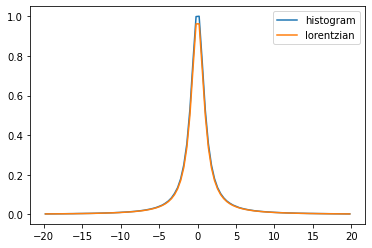

In [143]:
n=10000000
devs=lor_dev(n) #get deviates from a lorentzian

devsBounded=devs[np.abs(devs)<20] #take only values in center for better plotting
a,bins=np.histogram(devsBounded, 100) #return values, bin edges
# print(b)

binC=0.5*(bins[1:]+bins[:-1]) #get centers of bins of hist

plt.plot(binC, a/a.max(), label="histogram")

#not that close tho
plt.plot(binC, lor(binC), label="lorentzian")
plt.legend()
# plt.ylim(-0.01, 1.2)
plt.show()

max accept prob: 0.9999997467993649
Accept fract: 0.636823091983015


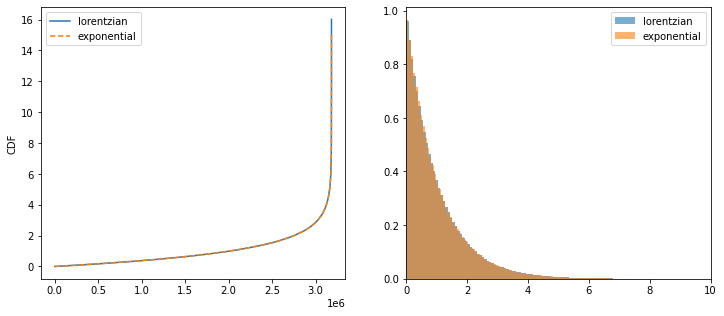

In [147]:
#I want only values greater than 0 for my exponential
devsPos=devs[devs>0]
CDF = expo_from_lor(devsPos)

#pretty good acceptance value
print("Accept fract:", len(CDF)/len(devsPos))

#get the exponential CDF from numpy to compare to
CDF_np = np.random.exponential(1, len(CDF))

CDF.sort()
CDF_np.sort()

fig, ax = plt.subplots(1, 2, figsize=(12,5))

#plotting the CDFs
ax[0].plot(CDF, label="lorentzian")
ax[0].plot(CDF_np, label="exponential", ls="--")
ax[0].set_ylabel("CDF")
ax[0].legend()

#plotting the histograms - scaled for ease
ax[1].hist(CDF, bins=200, label="lorentzian", alpha=0.6, density=True)
ax[1].hist(CDF_np, bins=200, label="exponential", alpha=0.6, density=True)
ax[1].legend()
ax[1].set_xlim(0, 10)
plt.show()

### Problem 3
Repeat problem 2, but now use a ratio-of-uniforms generator. If u goes from 0 to 1, what are your limits on v? How efficient is this generator, in terms of number of exponential deviates produced per uniform deviate? Make sure to plot the histogram again and show it still produces the correct answer.

Accept fract: 0.500287


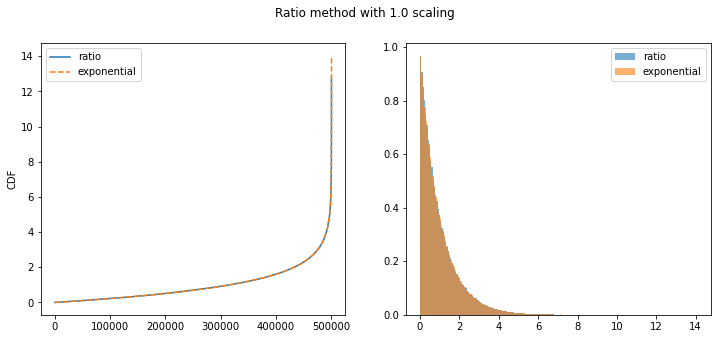

In [9]:
n=1000000
u=np.random.rand(n) #0-1
"""
As the ratio method just samples from values in np.exp(-ratio/2), we need this ratio to match the 
exponenent.
"""
scale=1.0
v=scale*np.random.rand(n)

ratio = v/u
acc = u < np.exp(-ratio)**(0.5) #using our ratio 
CDF = ratio[acc]

CDF_np = np.random.exponential(scale, len(CDF)) # scale here makes PDF=1/scale * exp(-x/scale)

CDF.sort()
CDF_np.sort()

fig, ax = plt.subplots(1, 2, figsize=(12,5))

print("Accept fract:", len(CDF)/len(u)) #not as efficient as the previous method

fig.suptitle("Ratio method with {} scaling".format(scale))
#plotting the CDFs
ax[0].plot(CDF, label="ratio")
ax[0].plot(CDF_np, label="exponential", ls="--")
ax[0].set_ylabel("CDF")
ax[0].legend()

#plotting the histograms - scaled for ease
ax[1].hist(CDF, bins=200, label="ratio", alpha=0.6, density=True)
ax[1].hist(CDF_np, bins=200, label="exponential", alpha=0.6, density=True)
ax[1].legend()
plt.show()